In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import os

import folium

from IPython.display import display

In [2]:
paths = [
    "ratio_total\\2022",
    "ratio_total\\2025",
    "ratio_total\\2030",
    "ratio_total\\post_2030"
]

In [3]:
def plt_load_hydropower_data(paths):
    """Load and combine hydropower data from multiple files into a single GeoDataFrame."""
    combined_gdf = gpd.GeoDataFrame()

    for path in paths:
        # Load hydropower data from .gpkg file
        hydropower_gdf = gpd.read_file(os.path.join(path, 'hydropower_dams.gpkg'))

        # Extract year from the path and add it as a column
        year = os.path.basename(path)  # Extract the year from the path
        hydropower_gdf['Scenario'] = year

        # Append to the combined GeoDataFrame
        combined_gdf = pd.concat([combined_gdf, hydropower_gdf], ignore_index=True)
       
    return combined_gdf


def plt_hydropower_scenarios(hydropower_gdf):
    """Plot hydropower plants with different colors based on their scenario using Cartopy."""
    # Define colors for different scenarios
    color_map = {
        '2022': 'blue',
        '2025': 'green',
        '2030': 'orange',
        'post_2030': 'red'
    }
    
    # Create a map with Cartopy
    fig, ax = plt.subplots(figsize=(14, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Add features to the map
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgrey')  # Neutral land color
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())  # Adjust as needed for Laos

    # Plot hydropower plants with different colors
    for year in ['2022', '2025', '2030', 'post_2030']:
        # Create a mask for hydropower plants added in the current year
        current_year_mask = hydropower_gdf['Scenario'] == year
        
        # For years after 2022, exclude plants that were already added in earlier years
        if year != '2022':
            previous_years = ['2022'] if year == '2025' else ['2022', '2025']
            previous_plants = hydropower_gdf[hydropower_gdf['Scenario'].isin(previous_years)]
            previous_geometries = set(previous_plants.geometry.apply(lambda x: x.wkt))
            current_year_mask = current_year_mask & ~hydropower_gdf.geometry.apply(lambda x: x.wkt).isin(previous_geometries)

        subset = hydropower_gdf[current_year_mask]
        
        # Plot dots
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[year],
            label=f'Added in {year}',
            s=80,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with increased size
    legend = ax.legend(loc='upper right', fontsize='large', title='Scenario')
    legend.get_frame().set_edgecolor('black')

    # Add title and labels with normal font settings
    # ax.set_title('Hydropower Plants in Laos by Scenario', fontsize=14, fontweight='normal', family='sans-serif')
    ax.set_xlabel('Longitude', fontsize=12, fontweight='normal', family='sans-serif')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='normal', family='sans-serif')
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios_cartopy.png', dpi=300, bbox_inches='tight')
    plt.show()

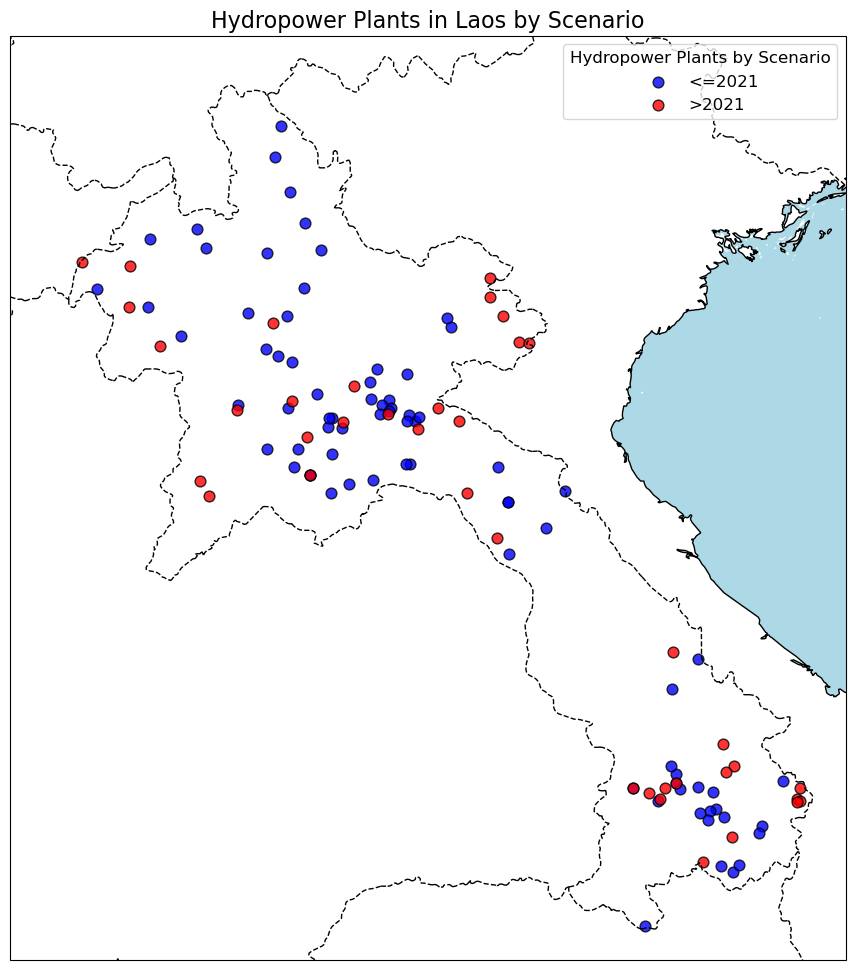

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def load_hydropower_data(paths):
    # Load the complete dataset
    return gpd.read_file(paths[0])  # Assuming post_2030 is the complete dataset

def plot_hydropower_scenarios(hydropower_gdf):
    # Define color map for each period
    color_map = {
        '<=2021': 'blue',
        '>2021': 'red'
    }
    
    # Create a Cartopy map with a specific projection
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set the background color of the plot area to white
    ax.set_facecolor('white')
    
    # Add features to the map with minimal styling to match the background
    # ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    # ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')
    
    # Define the year ranges and masks
    year_ranges = {
        '<=2021': (None, 2021),
        '>2021': (2021, None)
    }
    
    # Initialize masks
    used_indices = set()
    
    for label, (start_year, end_year) in year_ranges.items():
        if label == '>2030':
            # For '>2030', only include points not used in previous categories
            current_mask = ~hydropower_gdf.index.isin(used_indices)
        else:
            # For other periods, filter based on COD and update used_indices
            if start_year is None:
                current_mask = hydropower_gdf['COD'] <= end_year
            elif end_year is None:
                current_mask = hydropower_gdf['COD'] > start_year
            else:
                current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
            
            # Update used indices
            used_indices.update(hydropower_gdf[current_mask].index)
        
        # Plot the data
        subset = hydropower_gdf[current_mask]
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[label],
            label=f'{label}',
            s=60,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with larger font size
    legend = ax.legend(title='Hydropower Plants by Scenario', loc='upper right', fontsize='large')
    plt.setp(legend.get_title(), fontsize='large')
    
    # Set the title and labels with a more normal font
    ax.set_title('Hydropower Plants in Laos by Scenario', fontsize=16, fontweight='normal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())  # Adjust as needed for Laos
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
paths = [
    "ratio_total\\post_2030\\hydropower_dams.gpkg"  # Complete dataset with COD column
]

# Load the data and plot
hydropower_gdf = load_hydropower_data(paths)
plot_hydropower_scenarios(hydropower_gdf)


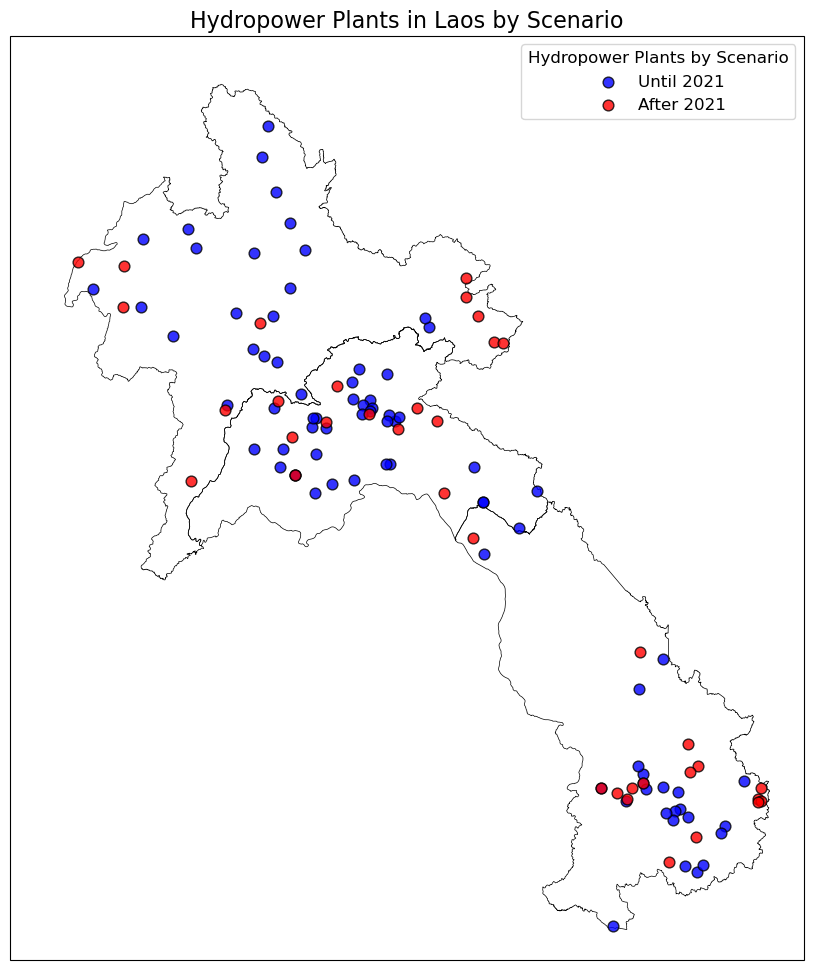

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def load_hydropower_data(paths):
    # Load the complete dataset
    return gpd.read_file(paths[0])  # Assuming post_2030 is the complete dataset

def plot_hydropower_scenarios(hydropower_gdf, areas_gdf):
    # Define color map for each period
    color_map = {
        'Until 2021': 'blue',
        'After 2021': 'red'
    }
    
    # Create a Cartopy map with a specific projection
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set the background color of the plot area to white
    ax.set_facecolor('white')
    
    # Add features to the map with minimal styling to match the background
    # ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue')
    # ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
    # ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    
    # Plot the areas
    areas_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # Define the year ranges and masks
    year_ranges = {
        'Until 2021': (None, 2021),
        'After 2021': (2021, None)
    }
    
    # Initialize masks
    used_indices = set()
    
    for label, (start_year, end_year) in year_ranges.items():
        if label == '>2030':
            # For '>2030', only include points not used in previous categories
            current_mask = ~hydropower_gdf.index.isin(used_indices)
        else:
            # For other periods, filter based on COD and update used_indices
            if start_year is None:
                current_mask = hydropower_gdf['COD'] <= end_year
            elif end_year is None:
                current_mask = hydropower_gdf['COD'] > start_year
            else:
                current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
            
            # Update used indices
            used_indices.update(hydropower_gdf[current_mask].index)
        
        # Plot the data
        subset = hydropower_gdf[current_mask]
        ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            color=color_map[label],
            label=f'{label}',
            s=60,  # Adjust size of dots for better appearance
            edgecolor='black',  # Border color for dots
            alpha=0.8,  # Dot opacity
            transform=ccrs.PlateCarree()  # Transform to match the map projection
        )
    
    # Add legend with larger font size
    legend = ax.legend(title='Hydropower Plants by Scenario', loc='upper right', fontsize='large')
    plt.setp(legend.get_title(), fontsize='large')
    
    # Set the title and labels with a more normal font
    ax.set_title('Hydropower Plants in Laos by Scenario', fontsize=16, fontweight='normal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())  # Adjust as needed for Laos
    
    # Save the plot as an image
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage
paths = [
    "ratio_total\\post_2030\\hydropower_dams.gpkg"  # Complete dataset with COD column
]

# Load the data and plot
hydropower_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Data_30\hydropower_dams_30.gpkg')

# Load the areas data
areas_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Parameters\areas_laos.geojson')

# Plot the hydropower scenarios with areas
plot_hydropower_scenarios(hydropower_gdf, areas_gdf)

In [39]:
def plot_hydropower_scenarios(hydropower_gdf, areas_gdf):
    # Define color map for each period
    color_map = {
        'Until 2021': 'blue',
        'After 2021': 'red'
    }
    
    # Create a Cartopy map with a specific projection
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Set the background color of the plot area to white
    ax.set_facecolor('white')
    
    # Plot the areas
    areas_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # Define the year ranges and masks
    year_ranges = {
        'Until 2021': (None, 2021),
        'After 2021': (2021, None)
    }
    
    # Initialize masks
    used_indices = set()
    
    for label, (start_year, end_year) in year_ranges.items():
        if label == '>2030':
            current_mask = ~hydropower_gdf.index.isin(used_indices)
        else:
            if start_year is None:
                current_mask = hydropower_gdf['COD'] <= end_year
            elif end_year is None:
                current_mask = hydropower_gdf['COD'] > start_year
            else:
                current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
            
        # Update used indices
        used_indices.update(hydropower_gdf[current_mask].index)
        
        # Get subset for this time period
        subset = hydropower_gdf[current_mask]
        
        # Create domestic and export masks
        domestic_mask = subset['Total capacity (MW)'] == subset['Domestic Capacity (MW)']
        
        # Plot domestic plants (triangles)
        ax.scatter(
            x=subset[domestic_mask].geometry.x,
            y=subset[domestic_mask].geometry.y,
            color=color_map[label],
            marker='^',
            label=f'{label} (Only domestic)',
            s=60,
            edgecolor='black',
            alpha=0.8,
            transform=ccrs.PlateCarree()
        )
        
        # Plot export+domestic plants (circles)
        ax.scatter(
            x=subset[~domestic_mask].geometry.x,
            y=subset[~domestic_mask].geometry.y,
            color=color_map[label],
            marker='o',
            label=f'{label} (Export+domestic)',
            s=60,
            edgecolor='black',
            alpha=0.8,
            transform=ccrs.PlateCarree()
        )
    
    # Add legend with larger font size
    legend = ax.legend(loc='upper right', 
                      fontsize='large')
    plt.setp(legend.get_title(), fontsize='large')
    
    # Set the title and labels
    # ax.set_title('Hydropower Plants in Laos by Scenario and Market Type', 
    #             fontsize=16, 
    #             fontweight='normal')
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    
    # Set extent to focus closely on Laos
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

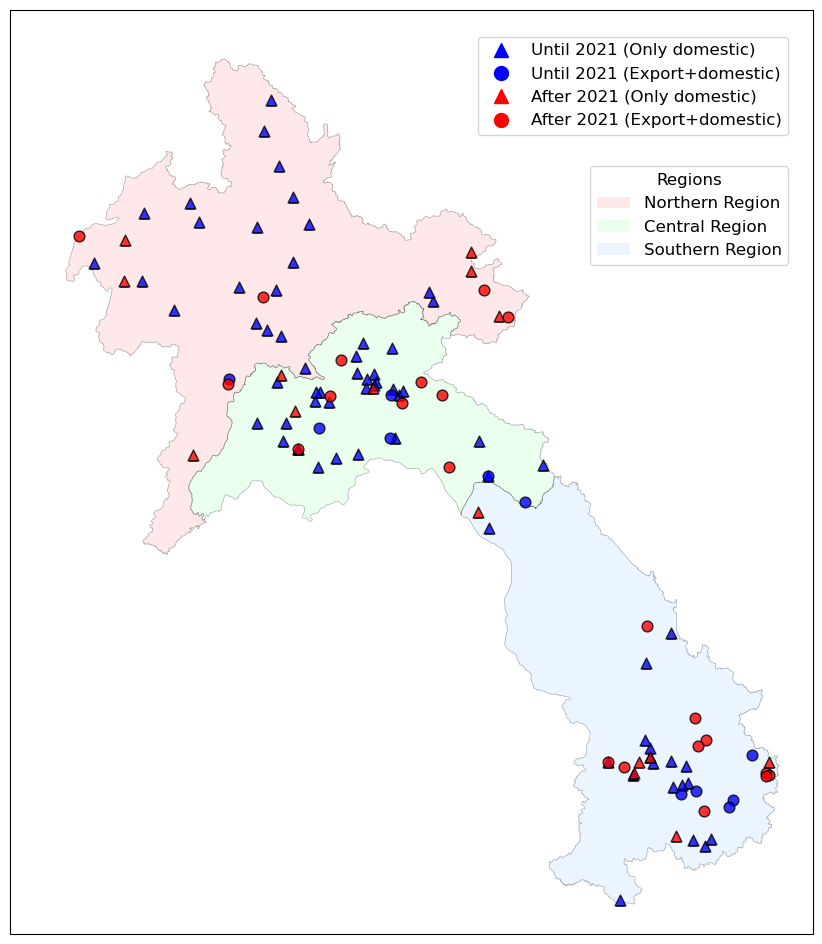

In [48]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_hydropower_scenarios(hydropower_gdf, areas_gdf):
    # Define color schemes
    hydro_colors = {
        'Until 2021': 'blue',
        'After 2021': 'red'
    }
    
    area_colors = {
        'north': '#FFB3BA',    # pastel red
        'centre': '#BAFFC9',   # pastel green
        'south': '#BAE1FF'     # pastel blue
    }
    
    area_labels = {
        'north': 'Northern Region',
        'centre': 'Central Region',
        'south': 'Southern Region'
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_facecolor('white')
    
    # Plot colored areas
    handles_areas = []
    for area_name in area_colors:
        area_subset = areas_gdf[areas_gdf['Area_new24'] == area_name]
        area_subset.plot(
            ax=ax,
            edgecolor='black',
            facecolor=area_colors[area_name],
            alpha=0.3,
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
        handles_areas.append(plt.Rectangle((0,0), 1, 1, 
                                        fc=area_colors[area_name], 
                                        alpha=0.3, 
                                        label=area_labels[area_name]))
    
    # Plot hydropower plants
    handles_hydro = []
    year_ranges = {
        'Until 2021': (None, 2021),
        'After 2021': (2021, None)
    }
    
    for label, (start_year, end_year) in year_ranges.items():
        if start_year is None:
            current_mask = hydropower_gdf['COD'] <= end_year
        elif end_year is None:
            current_mask = hydropower_gdf['COD'] > start_year
        else:
            current_mask = (hydropower_gdf['COD'] > start_year) & (hydropower_gdf['COD'] <= end_year)
        
        subset = hydropower_gdf[current_mask]
        domestic_mask = subset['Total capacity (MW)'] == subset['Domestic Capacity (MW)']
        
        # Plot domestic and export plants
        for is_domestic, marker in [(True, '^'), (False, 'o')]:
            mask = domestic_mask if is_domestic else ~domestic_mask
            ax.scatter(
                x=subset[mask].geometry.x,
                y=subset[mask].geometry.y,
                color=hydro_colors[label],
                marker=marker,
                s=60,
                edgecolor='black',
                alpha=0.8,
                transform=ccrs.PlateCarree()
            )
            handles_hydro.append(plt.Line2D([0], [0], 
                                          marker=marker, 
                                          color=hydro_colors[label], 
                                          label=f'{label} ({"Only domestic" if is_domestic else "Export+domestic"})',
                                          markerfacecolor=hydro_colors[label], 
                                          markersize=10,
                                          linestyle='None'))
    
    # Add legends in specific order
    hydro_legend = ax.legend(handles=handles_hydro,
                            bbox_to_anchor=(0.98, 0.98),
                            loc='upper right',
                            # title='Hydropower Plants',
                            fontsize='large')
    ax.add_artist(hydro_legend)
    
    areas_legend = ax.legend(handles=handles_areas, 
                           bbox_to_anchor=(0.98, 0.84),
                           loc='upper right', 
                           title='Regions',
                           fontsize='large')
    
    # Set legend titles
    plt.setp(hydro_legend.get_title(), fontsize='large')
    plt.setp(areas_legend.get_title(), fontsize='large')
    
    # Set labels and extent
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load and plot data
hydropower_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Data_30\hydropower_dams_30.gpkg')
areas_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Parameters\areas_laos.geojson')
plot_hydropower_scenarios(hydropower_gdf, areas_gdf)

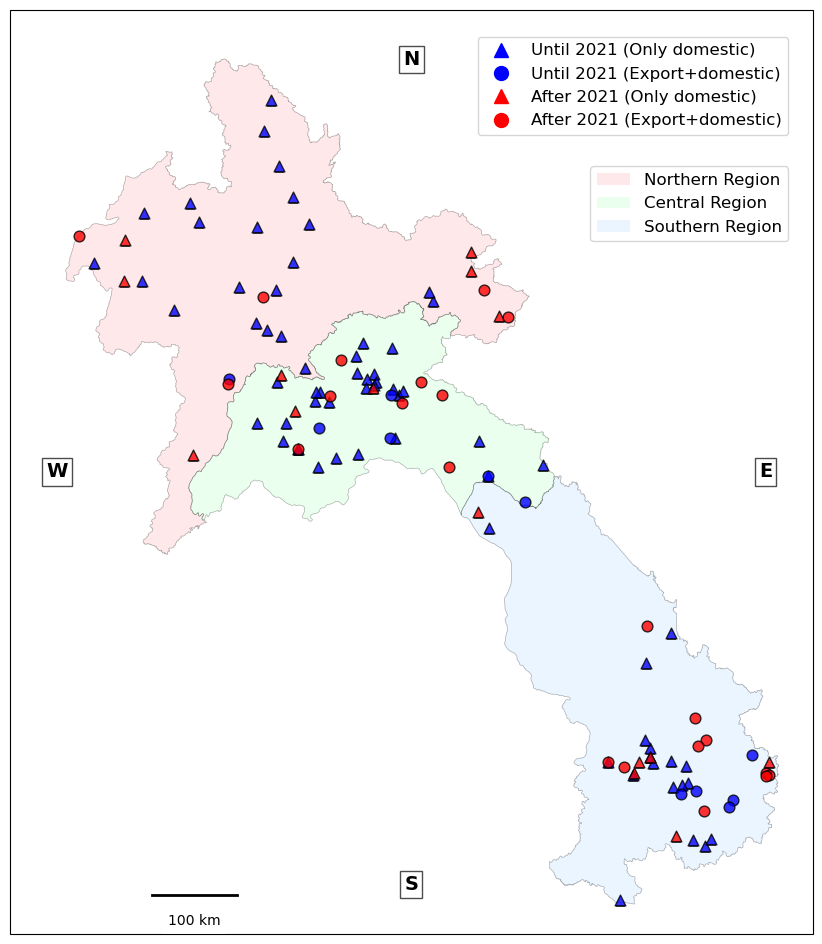

In [60]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import numpy as np

def add_scale_bar(ax, location=(101, 14)):
    """Add scale bar using simple line and text"""
    # Convert 100km to degrees (approximate)
    length_deg = 100/111  # 100km in degrees
    
    # Draw scale bar
    ax.plot([location[0], location[0] + length_deg], 
            [location[1], location[1]],
            color='black', 
            linewidth=2, 
            transform=ccrs.PlateCarree())
    
    # Add label
    ax.text(location[0] + length_deg/2, 
            location[1] - 0.2,
            '100 km', 
            transform=ccrs.PlateCarree(),
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=10,
            bbox=dict(facecolor='white', 
                     edgecolor='none', 
                     alpha=0.7))

def plot_hydropower_scenarios(hydropower_gdf, areas_gdf):
    # Define color schemes
    hydro_colors = {
        'Until 2021': 'blue',
        'After 2021': 'red'
    }
    
    area_colors = {
        'north': '#FFB3BA',
        'centre': '#BAFFC9',
        'south': '#BAE1FF'
    }
    
    area_labels = {
        'north': 'Northern Region',
        'centre': 'Central Region',
        'south': 'Southern Region'
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), 
                          subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_facecolor('white')
    
    # Plot areas with colors
    handles_areas = []
    for area_name in area_colors:
        area_subset = areas_gdf[areas_gdf['Area_new24'] == area_name]
        area_subset.plot(
            ax=ax,
            edgecolor='black',
            facecolor=area_colors[area_name],
            alpha=0.3,
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
        handles_areas.append(plt.Rectangle((0,0), 1, 1, 
                                        fc=area_colors[area_name], 
                                        alpha=0.3, 
                                        label=area_labels[area_name]))
    
    # Add cardinal directions
    # North
    ax.text(103.75, 22.5, 'N', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # East
    ax.text(107.5, 18.3, 'E', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # South
    ax.text(103.75, 14.1, 'S', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # West
    ax.text(100, 18.3, 'W', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # Plot hydropower plants
    handles_hydro = []
    year_ranges = {
        'Until 2021': (None, 2021),
        'After 2021': (2021, None)
    }
    
    for label, (start_year, end_year) in year_ranges.items():
        current_mask = (hydropower_gdf['COD'] <= end_year if start_year is None 
                       else hydropower_gdf['COD'] > start_year)
        
        subset = hydropower_gdf[current_mask]
        domestic_mask = subset['Total capacity (MW)'] == subset['Domestic Capacity (MW)']
        
        # Plot domestic and export plants
        for is_domestic, marker in [(True, '^'), (False, 'o')]:
            mask = domestic_mask if is_domestic else ~domestic_mask
            ax.scatter(
                x=subset[mask].geometry.x,
                y=subset[mask].geometry.y,
                color=hydro_colors[label],
                marker=marker,
                s=60,
                edgecolor='black',
                alpha=0.8,
                transform=ccrs.PlateCarree()
            )
            handles_hydro.append(plt.Line2D([0], [0], 
                                          marker=marker, 
                                          color=hydro_colors[label], 
                                          label=f'{label} ({"Only domestic" if is_domestic else "Export+domestic"})',
                                          markerfacecolor=hydro_colors[label], 
                                          markersize=10,
                                          linestyle='None'))
    
    # Add legends
    hydro_legend = ax.legend(handles=handles_hydro,
                            bbox_to_anchor=(0.98, 0.98),
                            loc='upper right',
                            fontsize='large')
    ax.add_artist(hydro_legend)
    
    areas_legend = ax.legend(handles=handles_areas, 
                           bbox_to_anchor=(0.98, 0.84),
                           loc='upper right', 
                           fontsize='large')
    
    # Set legend titles
    plt.setp(hydro_legend.get_title(), fontsize='large')
    plt.setp(areas_legend.get_title(), fontsize='large')
    
    # Add north arrow and scale bar
    add_scale_bar(ax)
    
    # Set labels and extent
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load and plot data
hydropower_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Data_30\hydropower_dams_30.gpkg')
areas_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Parameters\areas_laos.geojson')
plot_hydropower_scenarios(hydropower_gdf, areas_gdf)

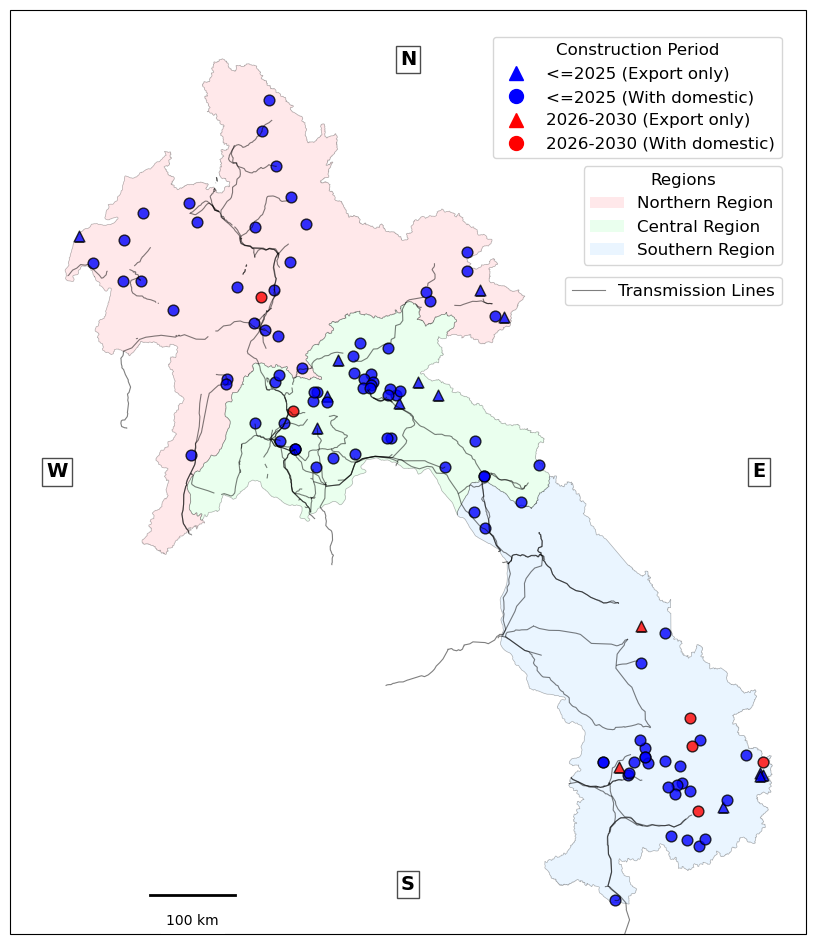

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import numpy as np

def add_scale_bar(ax, location=(101, 14)):
    """Add scale bar using simple line and text"""
    # Convert 100km to degrees (approximate)
    length_deg = 100/111  # 100km in degrees
    
    # Draw scale bar
    ax.plot([location[0], location[0] + length_deg], 
            [location[1], location[1]],
            color='black', 
            linewidth=2, 
            transform=ccrs.PlateCarree())
    
    # Add label
    ax.text(location[0] + length_deg/2, 
            location[1] - 0.2,
            '100 km', 
            transform=ccrs.PlateCarree(),
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=10,
            bbox=dict(facecolor='white', 
                     edgecolor='none', 
                     alpha=0.7))

def plot_hydropower_scenarios(hydropower_gdf, areas_gdf, transmission_gdf):
    # Define color schemes
    hydro_colors = {
        '<=2025': 'blue',
        '2026-2030': 'red'
    }
    
    area_colors = {
        'north': '#FFB3BA',
        'centre': '#BAFFC9',
        'south': '#BAE1FF'
    }
    
    area_labels = {
        'north': 'Northern Region',
        'centre': 'Central Region',
        'south': 'Southern Region'
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), 
                          subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_facecolor('white')
    
    # Plot areas with colors
    handles_areas = []
    for area_name in area_colors:
        area_subset = areas_gdf[areas_gdf['Area_new24'] == area_name]
        area_subset.plot(
            ax=ax,
            edgecolor='black',
            facecolor=area_colors[area_name],
            alpha=0.3,
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
        handles_areas.append(plt.Rectangle((0,0), 1, 1, 
                                        fc=area_colors[area_name], 
                                        alpha=0.3, 
                                        label=area_labels[area_name]))
    
    
    # transmission_gdf.plot(
    #     ax=ax,
    #     color='gray',
    #     linewidth=1,
    #     # alpha=0.5,
    #     transform=ccrs.PlateCarree()
    # )
    transmission_gdf.plot(
        ax=ax,
        color='black',
        linewidth=0.8,
        alpha=0.5,
        transform=ccrs.PlateCarree()
    )
    
    # Create matching line-style legend handle
    transmission_handle = plt.Line2D(
        [], [], 
        color='black',
        linewidth=0.8,
        alpha=0.5,
        label='Transmission Lines'
    )
    
    # Add cardinal directions
    # North
    ax.text(103.75, 22.5, 'N', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # East
    ax.text(107.5, 18.3, 'E', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # South
    ax.text(103.75, 14.1, 'S', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    # West
    ax.text(100, 18.3, 'W', 
            transform=ccrs.PlateCarree(),
            fontsize=14,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='white', 
                     edgecolor='black',
                     alpha=0.7,
                     pad=3))
    
    handles_hydro = []
    year_ranges = {
        '<=2025': (None, 2026),
        '2026-2030': (2026, 2030)
    }
    
    for label, (start_year, end_year) in year_ranges.items():
        current_mask = (hydropower_gdf['COD'] <= end_year if start_year is None 
                       else hydropower_gdf['COD'] > start_year)
        
        subset = hydropower_gdf[current_mask]
        # Modified mask: True for export-only plants
        export_only_mask = subset['Domestic Capacity (MW)'] == 0
        
        # Plot export-only plants (triangles)
        ax.scatter(
            x=subset[export_only_mask].geometry.x,
            y=subset[export_only_mask].geometry.y,
            color=hydro_colors[label],
            marker='^',
            s=60,
            edgecolor='black',
            alpha=0.8,
            transform=ccrs.PlateCarree()
        )
        handles_hydro.append(plt.Line2D([0], [0], 
                                      marker='^', 
                                      color=hydro_colors[label], 
                                      label=f'{label} (Export only)',
                                      markerfacecolor=hydro_colors[label], 
                                      markersize=10,
                                      linestyle='None'))
        
        # Plot plants with domestic capacity (circles)
        ax.scatter(
            x=subset[~export_only_mask].geometry.x,
            y=subset[~export_only_mask].geometry.y,
            color=hydro_colors[label],
            marker='o',
            s=60,
            edgecolor='black',
            alpha=0.8,
            transform=ccrs.PlateCarree()
        )
        handles_hydro.append(plt.Line2D([0], [0], 
                                      marker='o', 
                                      color=hydro_colors[label], 
                                      label=f'{label} (With domestic)',
                                      markerfacecolor=hydro_colors[label], 
                                      markersize=10,
                                      linestyle='None'))
    
    # Add legends
    # hydro_legend = ax.legend(handles=handles_hydro,
    #                         bbox_to_anchor=(0.98, 0.98),
    #                         loc='upper right',
    #                         fontsize='large')
    a = 12
    b = 14
    hydro_legend = ax.legend(handles=handles_hydro,
                            bbox_to_anchor=(0.98, 0.98),
                            loc='upper right',
                            fontsize=a,
                            title='Construction Period',
                            title_fontsize=b)
    ax.add_artist(hydro_legend)
    
    # areas_legend = ax.legend(handles=handles_areas, 
    #                        bbox_to_anchor=(0.98, 0.84),
    #                        loc='upper right', 
    #                        fontsize='large')
    areas_legend = ax.legend(handles=handles_areas, 
                           bbox_to_anchor=(0.98, 0.84),
                           loc='upper right',
                           fontsize=a,
                           title='Regions',
                           title_fontsize=b)
    ax.add_artist(areas_legend)
    
    transmission_legend = ax.legend([transmission_handle],
                                  ['Transmission Lines'],
                                  bbox_to_anchor=(0.98, 0.72),
                                  loc='upper right',
                                  fontsize=a)
    
    
    
    
    # Set legend titles
    plt.setp(hydro_legend.get_title(), fontsize='large')
    plt.setp(areas_legend.get_title(), fontsize='large')
    
    # Add north arrow and scale bar
    add_scale_bar(ax)
    
    # Set labels and extent
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load and plot data
transmission_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\Master\0_Thesis\0relevant_repositories\Laos-GeoH2-data-prep\Raw_Spatial_Data\open_transmission_lines.gpkg')
hydropower_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Data_30\hydropower_dams_30.gpkg')
areas_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Parameters\areas_laos.geojson')
plot_hydropower_scenarios(hydropower_gdf, areas_gdf,transmission_gdf)

## Plot for my publication (above is for Vignesh)

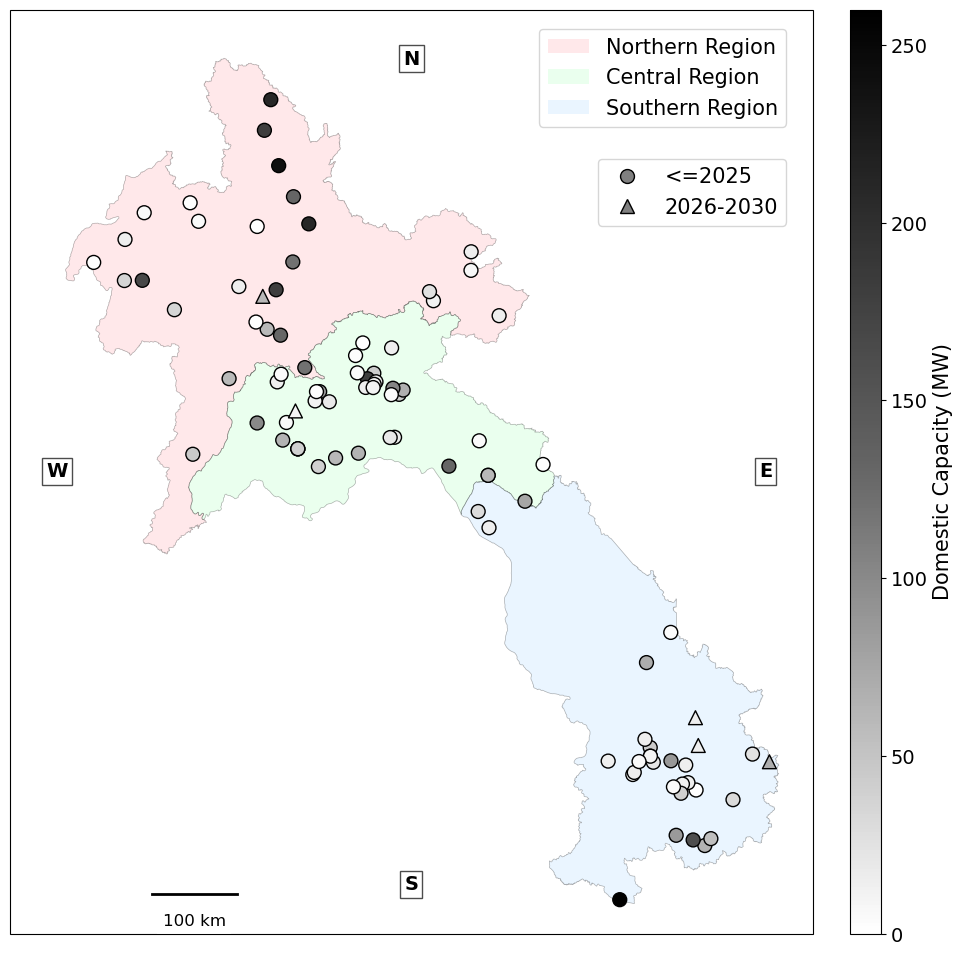

: 

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def add_scale_bar(ax, location=(101, 14)):
    length_deg = 100/111
    ax.plot([location[0], location[0] + length_deg], 
            [location[1], location[1]],
            color='black', 
            linewidth=2, 
            transform=ccrs.PlateCarree())
    ax.text(location[0] + length_deg/2, 
            location[1] - 0.2,
            '100 km', 
            transform=ccrs.PlateCarree(),
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=12,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

def plot_hydropower_scenarios(hydropower_gdf, areas_gdf):
    # Filter for domestic capacity
    hydropower_gdf = hydropower_gdf[hydropower_gdf['Domestic Capacity (MW)'] > 0]
    
    # Area definitions
    area_colors = {
        'north': '#FFB3BA',
        'centre': '#BAFFC9',
        'south': '#BAE1FF'
    }
    
    area_labels = {
        'north': 'Northern Region',
        'centre': 'Central Region',
        'south': 'Southern Region'
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), 
                          subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_facecolor('white')
    
    # Plot areas
    handles_areas = []
    for area_name in area_colors:
        area_subset = areas_gdf[areas_gdf['Area_new24'] == area_name]
        area_subset.plot(
            ax=ax,
            edgecolor='black',
            facecolor=area_colors[area_name],
            alpha=0.3,
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
        handles_areas.append(plt.Rectangle((0,0), 1, 1, 
                                        fc=area_colors[area_name], 
                                        alpha=0.3, 
                                        label=area_labels[area_name]))
    
  # Modify cardinal directions - remove East
    for direction, (x, y) in {'N': (103.75, 22.5), 
                             'E': (107.5, 18.3),
                             'S': (103.75, 14.1),
                             'W': (100, 18.3)}.items():
        ax.text(x, y, direction, 
                transform=ccrs.PlateCarree(),
                fontsize=14,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(facecolor='white', 
                         edgecolor='black',
                         alpha=0.7,
                         pad=3))
    
    # Hydropower plotting setup
    handles_hydro = []
    year_ranges = {
        '<=2025': (None, 2026),
        '2026-2030': (2026, 2030)
    }
    
    # Create white to black colormap
    colors = ['#FFFFFF', '#666666', '#000000']
    cmap = LinearSegmentedColormap.from_list("custom", colors)
    
    # Get actual capacity range
    vmin = 0
    vmax = hydropower_gdf['Domestic Capacity (MW)'].max()
    
    # Plot hydropower plants
    for label, (start_year, end_year) in year_ranges.items():
        current_mask = (hydropower_gdf['COD'] <= end_year if start_year is None 
                       else hydropower_gdf['COD'] > start_year)
        
        subset = hydropower_gdf[current_mask]
        marker = 'o' if label == '<=2025' else '^'
        
        scatter = ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            c=subset['Domestic Capacity (MW)'],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=100,
            marker=marker,
            edgecolor='black',
            alpha=1,
            transform=ccrs.PlateCarree(),
            label=label
        )
        handles_hydro.append(plt.Line2D([0], [0], 
                                      marker=marker,
                                      color='none',
                                      label=label,
                                      markerfacecolor='gray',
                                      markersize=10,
                                      markeredgecolor='black'))
    
    # Add compact colorbar
    # cax = plt.axes([0.95, 0.3, 0.02, 0.3])
    cbar = plt.colorbar(scatter, ax=ax, 
                       orientation='vertical',
                       fraction=0.046,  # width of colorbar
                       pad=0.04,        # space between plot and colorbar
                       aspect=30)       # height of colorbar
    cbar.set_label('Domestic Capacity (MW)', fontsize=15)
    
    # Add legends
    hydro_legend = ax.legend(handles=handles_hydro,
                            bbox_to_anchor=(0.98, 0.85),
                            loc='upper right',
                            fontsize=15)
    ax.add_artist(hydro_legend)
    
    areas_legend = ax.legend(handles=handles_areas, 
                           bbox_to_anchor=(0.98, 0.99),
                           loc='upper right',
                           fontsize=15)
    
    # Set legend titles
    # plt.setp(hydro_legend.get_title(), fontsize='large')
    # plt.setp(areas_legend.get_title(), fontsize='large')
    
    # Add scale bar
    add_scale_bar(ax)
    
    # Set labels and extent
    # ax.set_xlabel('Longitude', fontsize=12)
    # ax.set_ylabel('Latitude', fontsize=12)
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load and plot data
hydropower_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Data_30\hydropower_dams_30.gpkg')
areas_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Parameters\areas_laos.geojson')
plot_hydropower_scenarios(hydropower_gdf, areas_gdf)

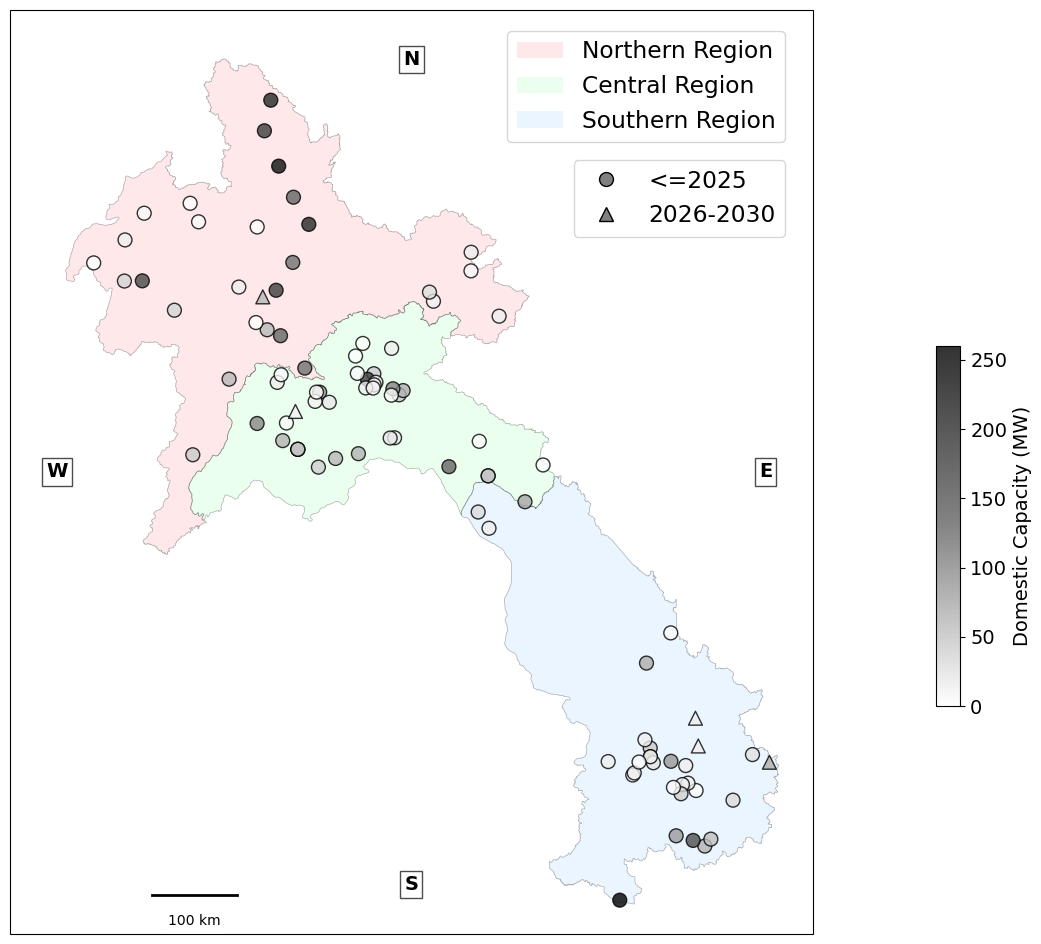

In [103]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def add_scale_bar(ax, location=(101, 14)):
    length_deg = 100/111
    ax.plot([location[0], location[0] + length_deg], 
            [location[1], location[1]],
            color='black', 
            linewidth=2, 
            transform=ccrs.PlateCarree())
    ax.text(location[0] + length_deg/2, 
            location[1] - 0.2,
            '100 km', 
            transform=ccrs.PlateCarree(),
            horizontalalignment='center',
            verticalalignment='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

def plot_hydropower_scenarios(hydropower_gdf, areas_gdf):
    # Filter for domestic capacity
    hydropower_gdf = hydropower_gdf[hydropower_gdf['Domestic Capacity (MW)'] > 0]
    
    # Area definitions
    area_colors = {
        'north': '#FFB3BA',
        'centre': '#BAFFC9',
        'south': '#BAE1FF'
    }
    
    area_labels = {
        'north': 'Northern Region',
        'centre': 'Central Region',
        'south': 'Southern Region'
    }
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 12), 
                          subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_facecolor('white')
    
    # Plot areas
    handles_areas = []
    for area_name in area_colors:
        area_subset = areas_gdf[areas_gdf['Area_new24'] == area_name]
        area_subset.plot(
            ax=ax,
            edgecolor='black',
            facecolor=area_colors[area_name],
            alpha=0.3,
            linewidth=0.5,
            transform=ccrs.PlateCarree()
        )
        handles_areas.append(plt.Rectangle((0,0), 1, 1, 
                                        fc=area_colors[area_name], 
                                        alpha=0.3, 
                                        label=area_labels[area_name]))
    
    # Add cardinal directions
    for direction, (x, y) in {'N': (103.75, 22.5), 
                             'E': (107.5, 18.3),
                             'S': (103.75, 14.1),
                             'W': (100, 18.3)}.items():
        ax.text(x, y, direction, 
                transform=ccrs.PlateCarree(),
                fontsize=14,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(facecolor='white', 
                         edgecolor='black',
                         alpha=0.7,
                         pad=3))
    
    # Hydropower plotting setup
    handles_hydro = []
    year_ranges = {
        '<=2025': (None, 2026),
        '2026-2030': (2026, 2030)
    }
    
    # Create white to black colormap
    colors = ['#FFFFFF', '#666666', '#000000']
    cmap = LinearSegmentedColormap.from_list("custom", colors)
    
    # Get actual capacity range
    vmin = 0
    vmax = hydropower_gdf['Domestic Capacity (MW)'].max()
    
    # Plot hydropower plants
    for label, (start_year, end_year) in year_ranges.items():
        current_mask = (hydropower_gdf['COD'] <= end_year if start_year is None 
                       else hydropower_gdf['COD'] > start_year)
        
        subset = hydropower_gdf[current_mask]
        marker = 'o' if label == '<=2025' else '^'
        
        scatter = ax.scatter(
            x=subset.geometry.x,
            y=subset.geometry.y,
            c=subset['Domestic Capacity (MW)'],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=100,
            marker=marker,
            edgecolor='black',
            alpha=0.8,
            transform=ccrs.PlateCarree(),
            label=label
        )
        handles_hydro.append(plt.Line2D([0], [0], 
                                      marker=marker,
                                      color='none',
                                      label=label,
                                      markerfacecolor='gray',
                                      markersize=10,
                                      markeredgecolor='black'))
    
    # Add compact colorbar
    cax = plt.axes([0.95, 0.3, 0.02, 0.3])
    cbar = plt.colorbar(scatter, cax=cax)
    cbar.set_label('Domestic Capacity (MW)', fontsize=14)
    
    # Add legends
    hydro_legend = ax.legend(handles=handles_hydro,
                            bbox_to_anchor=(0.98, 0.85),
                            loc='upper right',
                            fontsize='large')
    ax.add_artist(hydro_legend)
    
    areas_legend = ax.legend(handles=handles_areas, 
                           bbox_to_anchor=(0.98, 0.99),
                           loc='upper right',
                           fontsize='large')
    
    # Set legend titles
    plt.setp(hydro_legend.get_title(), fontsize='large')
    plt.setp(areas_legend.get_title(), fontsize='large')
    
    # Add scale bar
    add_scale_bar(ax)
    
    # Set labels and extent
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.set_extent([99.5, 108, 13.6, 23], crs=ccrs.PlateCarree())
    
    plt.savefig('hydropower_scenarios.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load and plot data
hydropower_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Data_30\hydropower_dams_30.gpkg')
areas_gdf = gpd.read_file(r'C:\Users\ls2823\OneDrive - Imperial College London\0_PUBLICATION\Repositories\GeoH2-Laos\Parameters\areas_laos.geojson')
plot_hydropower_scenarios(hydropower_gdf, areas_gdf)

## Requires borderfile

In [ ]:
import geopandas as gpd
import plotly.express as px
import pandas as pd
import os

def load_hydropower_data(paths):
    """Load and combine hydropower data from multiple files into a single GeoDataFrame."""
    combined_gdf = gpd.GeoDataFrame()

    for path in paths:
        # Load hydropower data from .gpkg file
        hydropower_gdf = gpd.read_file(os.path.join(path, 'hydropower_dams.gpkg'))

        # Extract year from the path and add it as a column
        year = os.path.basename(path)  # Extract the year from the path
        hydropower_gdf['Scenario'] = year

        # Append to the combined GeoDataFrame
        combined_gdf = pd.concat([combined_gdf, hydropower_gdf], ignore_index=True)
    
    return combined_gdf

def plot_hydropower_scenarios(hydropower_gdf, borders_path, output_path):
    """Plot hydropower plants with borders using Plotly and save the plot."""
    # Define colors for different scenarios
    color_map = {
        '2022': 'blue',
        '2025': 'green',
        '2030': 'orange',
        'post_2030': 'red'
    }
    
    # Create a color column for the Plotly plot
    hydropower_gdf['Color'] = hydropower_gdf['Scenario'].map(color_map)
    
    # Plot with Plotly Express
    fig = px.scatter_geo(
        hydropower_gdf,
        lon=hydropower_gdf.geometry.x,
        lat=hydropower_gdf.geometry.y,
        color='Color',
        color_discrete_map=color_map,
        labels={'Color': 'Scenario'},
        title='Hydropower Plants by Scenario',
        hover_name='Scenario',
        projection='natural earth'
    )
    
    # Load world borders from the GeoJSON file
    world_gdf = gpd.read_file(borders_path)
    
    # Add world borders to the Plotly figure
    fig.add_scattergeo(
        lon=world_gdf.geometry.centroid.x,
        lat=world_gdf.geometry.centroid.y,
        mode='lines',
        line=dict(width=0.5, color='black'),
        name='Country Borders'
    )

    # Save the plot to file
    fig.write_html(output_path)
    
# Define paths
paths = [
    "Resources\\0Temporal\\ratio_total\\2022",
    "Resources\\0Temporal\\ratio_total\\2025",
    "Resources\\0Temporal\\ratio_total\\2030",
    "Resources\\0Temporal\\ratio_total\\post_2030"
]

# Define the path to the world borders GeoJSON file
borders_path = 'path_to_your_borders_file.geojson'

# Load data
hydropower_gdf = load_hydropower_data(paths)

# Define output path for the plot
output_path = 'Laos_specific/hydropower_scenarios.html'

# Plot and save the figure
plot_hydropower_scenarios(hydropower_gdf, borders_path, output_path)
